In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns


WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Global seed set to 0


### Functions

In [2]:
def read_and_qc(sample_name, path):
    r""" This function reads the data for one 10X spatial experiment into the anndata object.
    It also calculates QC metrics. Modify this function if required by your workflow.

    :param sample_name: Name of the sample
    :param path: path to data
    """

    adata = sc.read_visium(path + str(sample_name),
                           count_file='filtered_feature_bc_matrix.h5', load_images=True)
    adata.var_names_make_unique(join='-')
    
    adata.obs['sample'] = sample_name
    
    # rename genes to ENSEMBL
    adata.var['SYMBOL'] = adata.var_names
    adata.var_names = adata.var['gene_ids']
    adata.var_names.name = None

    # Calculate QC metrics
    sc.pp.calculate_qc_metrics(adata, inplace=True)
    adata.var['mt'] = [gene.startswith('MT-') for gene in adata.var['SYMBOL']]
    adata.obs['mt_frac'] = adata[:, adata.var['mt'].tolist()].X.sum(1).A.squeeze()/adata.obs['total_counts']

    # add sample name to obs names
    adata.obs["sample"] = [str(i) for i in adata.obs['sample']]
    adata.obs_names = adata.obs["sample"] \
                          + '_' + adata.obs_names
    adata.obs.index.name = 'spot_id'

    return adata

def select_slide(adata, s, s_col='sample'):
    r""" This function selects the data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial experiments
    :param s: name of selected experiment
    :param s_col: column in adata.obs listing experiment name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

In [3]:
#meta = pd.read_csv('/lustre/scratch117/cellgen/team205/rl20/kidney_final/Visium/spaceranger/meta_visium.csv')
#meta

## Data, parameters

In [3]:
results_folder = '/home/jupyter/CTCL/Visium/cell2loc_out'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map_allsamples'

In [4]:
#celltype_key='annotation'
#sampleIDs = meta['sample_id']
#sampleIDs = list(map(str, sampleIDs))
#sp_data_folder = '/lustre/scratch117/cellgen/team205/rl20/kidney_final/spaceranger'
#sampleIDs

In [5]:
input_file = '/home/jupyter/visium_merge.h5ad'
adata_vis = sc.read_h5ad(input_file)

In [6]:
adata_vis.obs['sample'].value_counts()

spaceranger210_count_47757_HCA_sCTCL13876505-GRCh38-2020-A    1040
spaceranger210_count_47757_HCA_sCTCL13876503-GRCh38-2020-A     811
spaceranger210_count_47555_HCA_sCTCL13787193-GRCh38-2020-A     712
spaceranger210_count_47757_HCA_sCTCL13876504-GRCh38-2020-A     658
spaceranger210_count_47555_HCA_sCTCL13787192-GRCh38-2020-A     629
spaceranger210_count_47555_HCA_sCTCL13787190-GRCh38-2020-A     487
spaceranger210_count_47757_HCA_sCTCL13876502-GRCh38-2020-A     389
spaceranger210_count_47555_HCA_sCTCL13787191-GRCh38-2020-A     305
Name: sample, dtype: int64

## cell2location mapping

INFO     Using batches from adata.obs["sample"]                                              
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             


/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.


INFO     Successfully registered anndata object containing 5031 cells, 11843 vars, 8 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function view_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.


Anndata setup with scvi-tools version 0.14.6.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 5031  │
│             Vars             │ 11843 │
│            Labels            │   1   │
│           Batches            │   8   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

             SCVI Data Registry              
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │          adata.X          │
│ batch_indices │ adata.obs['_scvi_batch']  │
│    labels     │ adata.obs['_scvi_labels'] │
└───────────────┴───────────────────────────┘

                        Label Categories                        
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

                                      Batch Categories                                       
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Source Location ┃                       Categories                       ┃ scvi-tools Enc ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ adata.obs['samp │ spaceranger210_count_47555_HCA_sCTCL13787190-GRCh38-20 │       0        │
│                 │ spaceranger210_count_47555_HCA_sCTCL13787191-GRCh38-20 │       1        │
│                 │ spaceranger210_count_47555_HCA_sCTCL13787192-GRCh38-20 │       2        │
│                 │ spaceranger210_count_47555_HCA_sCTCL13787193-GRCh38-20 │       3        │
│                 │ spaceranger210_count_47757_HCA_sCTCL13876502-GRCh38-20 │       4        │
│                 │ spaceranger210_count_47757_HCA_sCTCL13876503-GRCh38-20 │       5        │
│                 │ spaceranger210_count_47757_HCA_sCTCL13876504-GRCh38-20 │       6        │
│                 │ spaceranger210_count_47757_HCA_sCTCL13876505-GRCh38-20 │       7        │
└─────────────────┴────────────────────────────────────────────────────────┴────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 20000/20000: 100%|██████████| 20000/20000 [1:08:18<00:00,  4.88it/s, v_num=1, elbo_train=5.58e+7]
CPU times: user 50min 36s, sys: 18min 17s, total: 1h 8min 54s
Wall time: 1h 8min 55s


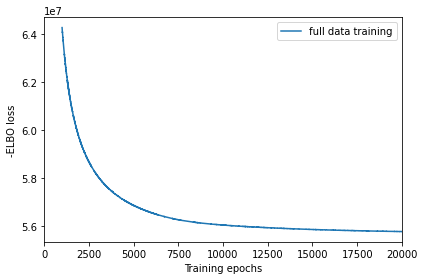

In [7]:
%%time

    
# read in reference signatures
inf_aver = pd.read_csv(f"{ref_run_name}/inf_aver.csv", index_col=0)

# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)
adata_vis = adata_vis[:, intersect].copy()
inf_aver = inf_aver.loc[intersect, :].copy()

# prepare anndata for cell2location model
scvi.data.setup_anndata(adata=adata_vis, batch_key="sample")
scvi.data.view_anndata_setup(adata_vis)

# create and train the model
mod = cell2location.models.Cell2location(
    adata_vis, cell_state_df=inf_aver, 
    # the expected average cell abundance: tissue-dependent 
    # hyper-prior which can be estimated from paired histology:
    N_cells_per_location=7,
    # hyperparameter controlling normalisation of
    # within-experiment variation in RNA detection (using default here):
    detection_alpha=20
) 

mod.train(max_epochs=20000, 
          # train using full data (batch_size=None)
          batch_size=None, 
          # use all data points in training because 
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True)

# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);


Sampling global variables, sample: 100%|██████████| 999/999 [00:37<00:00, 26.55it/s]


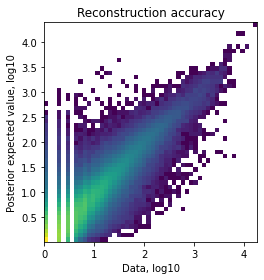

In [8]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_vis = mod.export_posterior(
    adata_vis, sample_kwargs={'num_samples': 1000, 'batch_size': mod.adata.n_obs, 'use_gpu': True}
)

# Save model
mod.save(f"{run_name}", overwrite=True)

# Save anndata object with results
adata_vis.write(f"{run_name}/sp.h5ad")

# Examine reconstruction accuracy to assess if there are any issues with mapping
# the plot should be roughly diagonal, strong deviations will signal problems
mod.plot_QC()

In [ ]:
from cell2location import run_colocation
res_dict, adata_vis = run_colocation(
    adata_vis,
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': np.arange(5, 30), # IMPORTANT: use a wider range of the number of factors (5-30)
      'sample_name_col': 'sample', # columns in adata_vis.obs that identifies sample
      'n_restarts': 3 # number of training restarts
    },
    export_args={'path': f'{run_name}/CoLocatedComb/'}
)

### Analysis name: CoLocatedGroupsSklearnNMF_5combinations_5031locations_47factors


/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


### Analysis name: CoLocatedGroupsSklearnNMF_6combinations_5031locations_47factors


/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


### Analysis name: CoLocatedGroupsSklearnNMF_7combinations_5031locations_47factors


/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


### Analysis name: CoLocatedGroupsSklearnNMF_8combinations_5031locations_47factors


/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


### Analysis name: CoLocatedGroupsSklearnNMF_9combinations_5031locations_47factors


/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


### Analysis name: CoLocatedGroupsSklearnNMF_10combinations_5031locations_47factors


/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


### Analysis name: CoLocatedGroupsSklearnNMF_11combinations_5031locations_47factors


/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


### Analysis name: CoLocatedGroupsSklearnNMF_12combinations_5031locations_47factors


/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


### Analysis name: CoLocatedGroupsSklearnNMF_13combinations_5031locations_47factors


/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


### Analysis name: CoLocatedGroupsSklearnNMF_14combinations_5031locations_47factors


/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


### Analysis name: CoLocatedGroupsSklearnNMF_15combinations_5031locations_47factors


/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


### Analysis name: CoLocatedGroupsSklearnNMF_16combinations_5031locations_47factors


/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


### Analysis name: CoLocatedGroupsSklearnNMF_17combinations_5031locations_47factors


/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


### Analysis name: CoLocatedGroupsSklearnNMF_18combinations_5031locations_47factors


/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


### Analysis name: CoLocatedGroupsSklearnNMF_19combinations_5031locations_47factors


/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


### Analysis name: CoLocatedGroupsSklearnNMF_20combinations_5031locations_47factors


/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


### Analysis name: CoLocatedGroupsSklearnNMF_21combinations_5031locations_47factors


/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


### Analysis name: CoLocatedGroupsSklearnNMF_22combinations_5031locations_47factors


/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


### Analysis name: CoLocatedGroupsSklearnNMF_23combinations_5031locations_47factors


/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


### Analysis name: CoLocatedGroupsSklearnNMF_24combinations_5031locations_47factors


/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


### Analysis name: CoLocatedGroupsSklearnNMF_25combinations_5031locations_47factors


/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


### Analysis name: CoLocatedGroupsSklearnNMF_26combinations_5031locations_47factors


/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 Unable to allocate 44.5 MiB for an array with shape (1457, 2000, 4) and data type float32
### Analysis name: CoLocatedGroupsSklearnNMF_27combinations_5031locations_47factors


/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


Some error in plotting with scanpy or `cell2location.plt.plot_factor_spatial()`
 Unable to allocate 33.3 MiB for an array with shape (1457, 2000, 3) and data type float32
### Analysis name: CoLocatedGroupsSklearnNMF_28combinations_5031locations_47factors


/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead
/opt/conda/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1422: FutureWarning: `alpha` was deprecated in version 1.0 and will be removed in 1.2. Use `alpha_W` and `alpha_H` instead


In [ ]:
from cell2location import run_colocation
res_dict, adata_vis = run_colocation(
    adata_vis,
    model_name='CoLocatedGroupsSklearnNMF',
    train_args={
      'n_fact': np.arange(16, 20), # IMPORTANT: use a wider range of the number of factors (5-30)
      'sample_name_col': 'sample', # columns in adata_vis.obs that identifies sample
      'n_restarts': 3 # number of training restarts
    },
    export_args={'path': f'{run_name}/CoLocatedComb_16to20/'}
)